In [50]:
from tensorboard.backend.event_processing import event_accumulator      
import numpy as np
import pandas as pd
from glob import glob
import sys
import tensorboard.plugins.hparams as hparams
from tensorboard.plugins.hparams import plugin_data_pb2
import tqdm
import re
import os.path
import os

interesting_keys = ['episode_reward_mean', "episode_len_mean", 'episodes_total', 'custom_metrics/inv', "time_this_iter_s", 'custom_metrics/accept']
hist_keys = ["inv", "accept"]


def create_df(inpath):
    sg = {event_accumulator.COMPRESSED_HISTOGRAMS: 1,
          event_accumulator.IMAGES: 1,
          event_accumulator.AUDIO: 1,
          event_accumulator.SCALARS: 0,
          event_accumulator.HISTOGRAMS: 0}
    ea = event_accumulator.EventAccumulator(inpath, size_guidance=sg)
    ea.Reload()
    scalar_tags = ea.Tags()['scalars']
    df = pd.DataFrame()
    events = ea.Scalars("ray/tune/episode_reward_mean")
    ids = [x.step for x in events]
    ids_s = set(x.step for x in events)
    df['step'] = ids
    walltimes = [x.wall_time for x in events]
    df['walltime'] = walltimes
    df['totalwalltime'] = walltimes[-1] - walltimes[0]
    df.set_index('step', inplace=True)
    for tag in hist_keys:
        fulltag = 'ray/tune/hist_stats/' + tag
        events = ea.Histograms(fulltag)
        indexes = [x.step for x in events if x.step in ids_s]
        mins = [x.histogram_value.min for x in events if x.step in ids_s]
        maxs = [x.histogram_value.max for x in events if x.step in ids_s]
        means = [x.histogram_value.sum / x.histogram_value.num for x in events if x.step in ids_s]
        stds = [np.sqrt(x.histogram_value.sum_squares / x.histogram_value.num - (x.histogram_value.sum / x.histogram_value.num)**2) for x, mean in zip(events, means) if x.step in ids_s]
        print(events[-1].histogram_value)
        df.loc[indexes, tag+"_max"] = maxs
        df.loc[indexes, tag+"_min"] = mins
        df.loc[indexes, tag+"_mean"] = means
        df.loc[indexes, tag+"_std"] = stds
    for tag in interesting_keys:
        fultag = 'ray/tune/' + tag
        success = False
        for i in range(3):
            try:
                events = ea.Scalars(fultag)
            except KeyError:
                fultag+= "_mean"
            else:
                success = True
                break
        if not success:
            raise KeyError(fultag)

        scalars = np.array([x.value for x in events if x.step in ids_s])
        indexes = np.array([x.step for x in events if x.step in ids_s])
        df.loc[indexes, tag] = scalars

    df.reset_index(inplace=True)
    return df


def removeprefix(self: str, prefix: str, /) -> str:
    if self.startswith(prefix):
        return self[len(prefix):]
    else:
        return self[:]

In [51]:
mainpath = 'logs/paperrun/e200000/ppobiglr/**/*tfevents*'
first, _ = mainpath.split("**")

shortname = ''.join(removeprefix(first, 'logs/paperrun').split('/'))
print(shortname)
figdir = "figures/" + shortname + "/"
os.makedirs(figdir, exist_ok=True)

e200000ppobiglr


In [52]:
fuldfs = []
runid = 0
forcereload = True

if not forcereload and os.path.exists(first + "/sumup.df.pkl"):
    alldf = pd.read_pickle(first + "sumup.df.pkl")
else:
    for path in tqdm.tqdm(glob(mainpath, recursive=True)):
        try:
            curdf = create_df(path)
        except Exception as e:
            raise e
            print(path)
            print(type(e), e)
        else:
            curdf['run'] = runid
            curdf['badsiteprob'] = float(re.search("good_site_prob=(.+),", path).group(1))
            fuldfs.append(curdf)
            runid += 1
    alldf = pd.concat(fuldfs)
    first, _ = mainpath.split("**")

    alldf.to_pickle(first + "/sumup.df.pkl")


  0%|          | 0/127 [00:05<?, ?it/s]

HistogramValue(min=7.840484142303467, max=7.869119644165039, num=6604.0, sum=51873.364270210266, sum_squares=407457.10752123635, bucket_limit=[7.466637793298873, 8.213301572628762], bucket=[0.0, 6604.0])


ValueError: Must have equal len keys and value when setting with an ndarray

In [28]:
figwidth = 3.3

In [29]:
binsize = 1000
mode = "ppo"
ps = [1, 0.5, 0.2, 0.1]
if "true_episode_reward_mean" not in alldf.columns:
    alldf["true_episode_reward_mean"] = alldf["episode_reward_mean"]
    if "cma" not in mainpath: 
        alldf["episode_reward_mean"] = alldf["true_episode_reward_mean"] / 2
if "p" not in alldf.columns:
    alldf["p"] = alldf["badsiteprob"]

if "cma" not in mainpath: 
    mode = "cma"
else:
    mode = "ppo"
alldf["episode_bin_right"] = alldf["episodes_total"].apply(lambda x: (x // binsize + 1) * binsize )
alldf["step_bin_right"] = alldf["step"].apply(lambda x: (x // binsize + 1) * binsize )
alldf = alldf.query("p in @ps").copy()

In [31]:
print(alldf.query("episode_bin_right >= 200000").groupby(["p"])["run"].nunique())

p
0.1    15
0.2    22
0.5    24
1.0    24
Name: run, dtype: int64


In [7]:
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
sns.set()
sns.set_palette('colorblind')
sns.set_context('paper', font_scale=0.75)
sns.set_style("whitegrid")
figsize=(figwidth, figwidth/1.5)

In [8]:
from pandas.api.types import CategoricalDtype

epcollapsed = alldf.groupby(["p", "run", "episode_bin_right"], as_index=False).mean()
stepcollapsed = alldf.groupby(["p", "run", "step_bin_right"], as_index=False).mean()
pcat = CategoricalDtype(ps, ordered=True)
epcollapsed["p"] = epcollapsed["p"].astype(pcat)
stepcollapsed["p"] = stepcollapsed["p"].astype(pcat)
alldf["p"] = alldf["p"].astype(pcat)

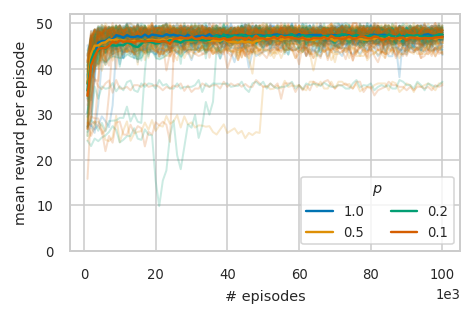

In [9]:
fig = plt.figure(figsize=figsize)
ax = fig.gca()
sns.lineplot(
    data=epcollapsed, x="episode_bin_right", y='episode_reward_mean', hue="p",
    estimator=None, alpha=0.2, linewidth=1, ax=ax, units="run", legend=False
)

sns.lineplot(data=epcollapsed, x="episode_bin_right", y='episode_reward_mean', hue="p", ax=ax)

ax.ticklabel_format(axis="x", scilimits=(3, 3))
plt.ylim(0, 52)
plt.ylabel('mean reward per episode')
plt.xlabel('# episodes')
plt.legend(ncol=2, title="$p$")
plt.tight_layout()
plt.savefig(figdir + "reward_mean_synth.pdf")

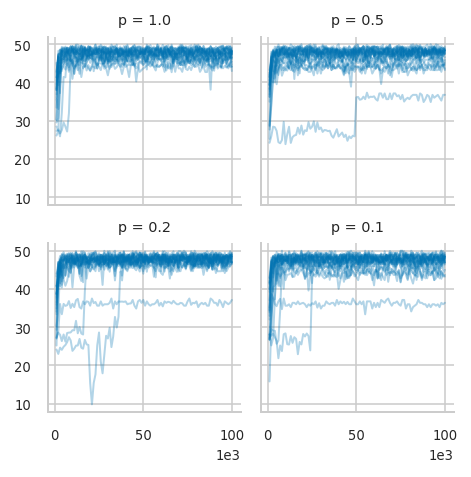

In [10]:
g = sns.FacetGrid(data=epcollapsed, col="p", col_wrap=2, height=(figwidth/2), aspect=1)
g.map_dataframe(sns.lineplot, x="episode_bin_right", y='episode_reward_mean',
        estimator=None, alpha=0.3, linewidth=1, units="run")
#g.map_dataframe(sns.lineplot, x="episode_bin_right", y='episode_reward_mean')
for ax in g.axes:
    ax.ticklabel_format(axis="x", scilimits=(3, 3))
g.tight_layout()
g.savefig(figdir + "reward_mean_detail.pdf")

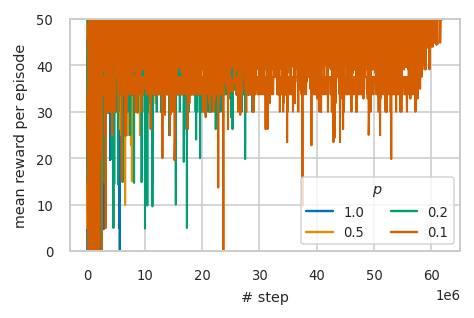

In [11]:
fig = plt.figure(figsize=figsize)
ax = fig.gca()
sns.lineplot(
        data=stepcollapsed, x="step_bin_right", y='episode_reward_mean', hue="p",
        estimator=None, linewidth=1, ax=ax, units="run"
    )
ax.ticklabel_format(axis="x", scilimits=(6, 6))

plt.ylim(0, 50)
plt.ylabel('mean reward per episode')
plt.xlabel('# step')
plt.legend(ncol=2, title="$p$")
plt.tight_layout()
plt.savefig(figdir + "reward_mean_synth_step.pdf")

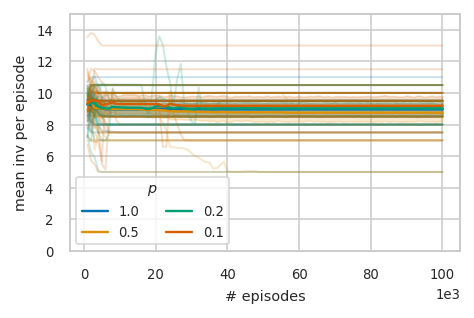

In [12]:
fig = plt.figure(figsize=figsize)
ax = fig.gca()
sns.lineplot(
        data=epcollapsed, x="episode_bin_right", y='custom_metrics/inv', hue="p",
        estimator=None, alpha=0.2, linewidth=1, ax=ax, units="run", legend=False
    )

sns.lineplot(data=epcollapsed, x="episode_bin_right", y='custom_metrics/inv', hue="p", ax=ax)


plt.ylim(0, 15)
plt.ylabel('mean inv per episode')
plt.xlabel('# episodes')
plt.legend(ncol=2, title="$p$")
ax.ticklabel_format(axis="x", scilimits=(3, 3))
plt.tight_layout()
plt.savefig(figdir + "inv_mean_synth.pdf")

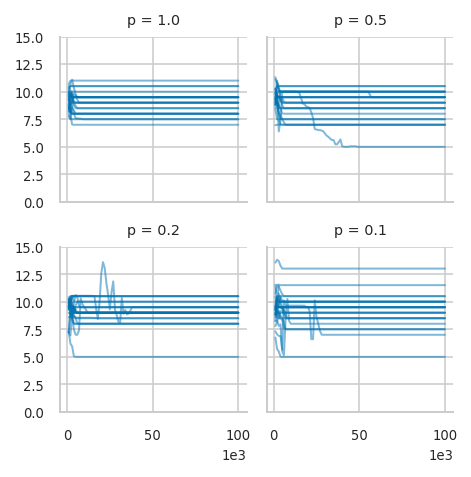

In [13]:
g = sns.FacetGrid(data=epcollapsed, col="p", col_wrap=2, height=figwidth/(1*2), aspect=1, sharex=True)
g.map_dataframe(sns.lineplot, x="episode_bin_right", y='custom_metrics/inv',
        estimator=None, alpha=0.5, linewidth=1, units="run")
#g.map_dataframe(sns.lineplot, x="episode_bin_right", y='custom_metrics/inv')
for ax in g.axes:
    ax.ticklabel_format(axis="x", scilimits=(3, 3))
    ax.set_ylim(0, 15)
g.tight_layout()
g.savefig(figdir + "inv_mean_details.pdf")

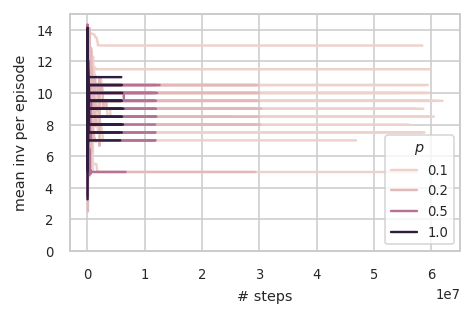

In [14]:
plt.figure(figsize=figsize)

sns.lineplot(data=alldf, x="step", y='custom_metrics/inv', hue="badsiteprob", units="run", estimator=None)
plt.ylim(0, 15)
plt.ylabel('mean inv per episode')
plt.xlabel('# steps')
plt.legend(title="$p$")
plt.tight_layout()
plt.savefig(figdir + "inv_mean_synth_step.pdf")

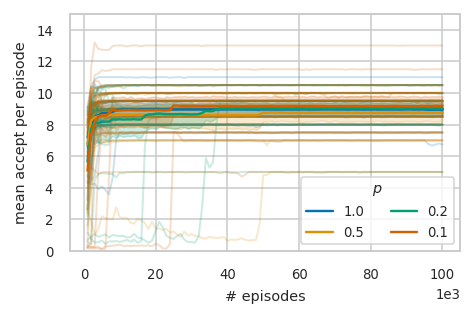

In [15]:
fig = plt.figure(figsize=figsize)
ax = fig.gca()
sns.lineplot(
        data=epcollapsed, x="episode_bin_right", y='custom_metrics/accept', hue="p",
        estimator=None, alpha=0.2, linewidth=1, ax=ax, units="run", legend=False
    )

sns.lineplot(data=epcollapsed, x="episode_bin_right", y='custom_metrics/accept', hue="p", ax=ax)


plt.ylim(0, 15)
plt.ylabel('mean accept per episode')
plt.xlabel('# episodes')
plt.legend(title="$p$", ncol=2)
ax.ticklabel_format(axis="x", scilimits=(3, 3))
plt.tight_layout()
plt.savefig(figdir + "accept_mean_synth.pdf")

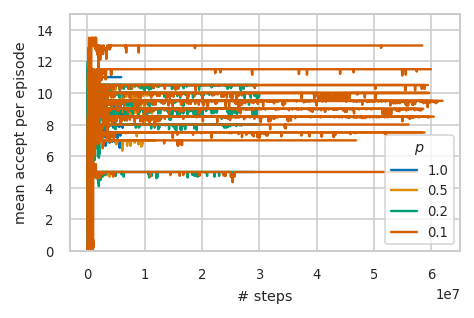

In [16]:
plt.figure(figsize=figsize)

sns.lineplot(data=alldf, x="step", y='custom_metrics/accept', hue="p", units="run", estimator=None)
plt.ylim(0, 15)
plt.ylabel('mean accept per episode')
plt.xlabel('# steps')
plt.legend(title="$p$")
plt.tight_layout()
plt.savefig(figdir + "accept_mean_step.pdf")

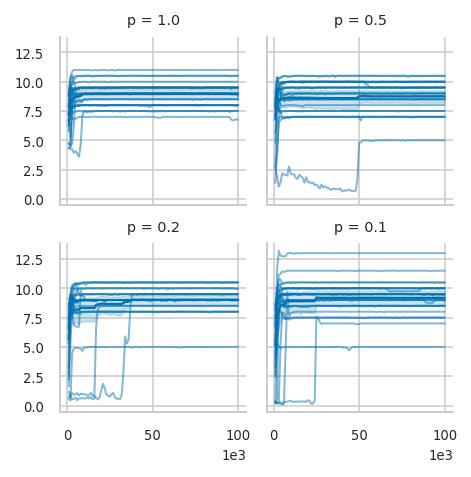

In [17]:
g = sns.FacetGrid(data=epcollapsed, col="p", col_wrap=2, height=figwidth/(1*2), aspect=1)
g.map_dataframe(sns.lineplot, x="episode_bin_right", y='accept_mean',
        estimator=None, alpha=0.5, linewidth=1, units="run")
g.map_dataframe(sns.lineplot, x="episode_bin_right", y='accept_mean')
for ax in g.axes:
    ax.ticklabel_format(axis="x", scilimits=(3, 3))
g.tight_layout()
plt.savefig(figdir + "accept_mean_detail.pdf")

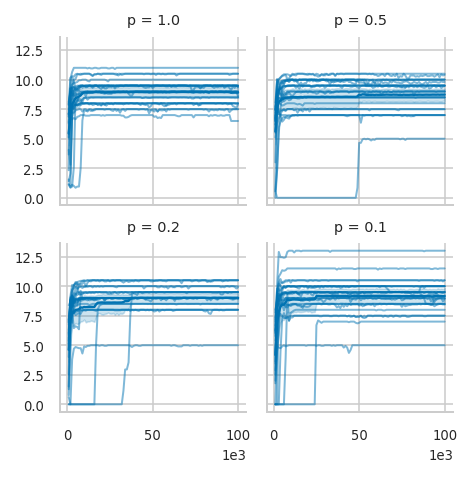

In [18]:
g = sns.FacetGrid(data=epcollapsed, col="p", col_wrap=2, height=figwidth/(1*2), aspect=1)
g.map_dataframe(sns.lineplot, x="episode_bin_right", y='accept_min',
        estimator=None, alpha=0.5, linewidth=1, units="run")
g.map_dataframe(sns.lineplot, x="episode_bin_right", y='accept_min')
for ax in g.axes:
    ax.ticklabel_format(axis="x", scilimits=(3, 3))
g.tight_layout()
plt.savefig(figdir + "accept_min_detail.pdf")

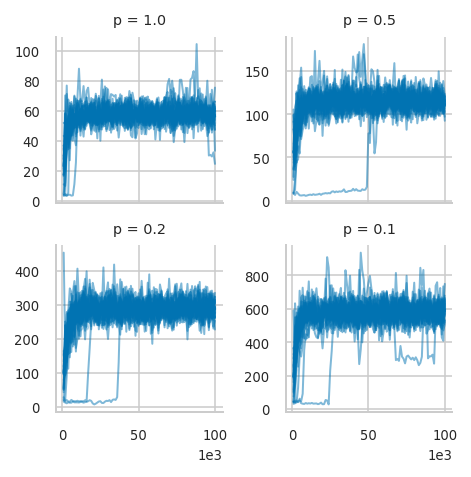

In [19]:
g = sns.FacetGrid(data=epcollapsed, col="p", col_wrap=2, height=(figwidth/(1*2)), aspect=1, sharey=False)
g.map_dataframe(sns.lineplot, x="episode_bin_right", y='episode_len_mean',
        estimator=None, alpha=0.5, linewidth=1, units="run")
g.map_dataframe(sns.lineplot, x="episode_bin_right", y='episode_len_mean')
for ax in g.axes:
    ax.ticklabel_format(axis="x", scilimits=(3, 3))
g.tight_layout()
plt.savefig(figdir + "episode_mean_detail.pdf")

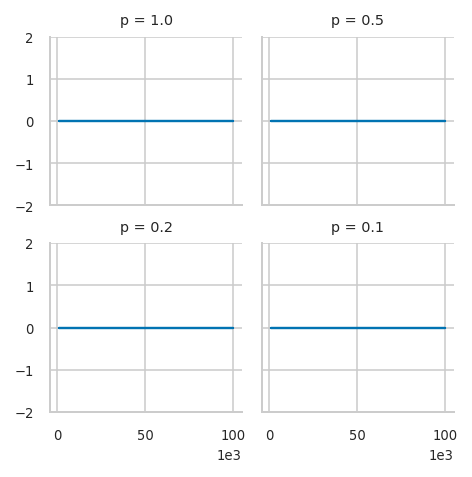

In [21]:
g = sns.FacetGrid(data=epcollapsed, col="p", col_wrap=2, height=figwidth/(1*2), aspect=1)
g.map_dataframe(sns.lineplot, x="episode_bin_right", y='inv_std',
        estimator=None, alpha=0.5, linewidth=1, units="run")
g.map_dataframe(sns.lineplot, x="episode_bin_right", y='inv_std')
for ax in g.axes:
    ax.ticklabel_format(axis="x", scilimits=(3, 3))
g.tight_layout()
g.set(ylim=(-2, 2))
plt.savefig(figdir + "inv_std_detail.pdf")

p
1.0    23
0.5    24
0.2    24
0.1    24
Name: run, dtype: int64